In [ ]:
!pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import math

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [3]:
def add_one(control_wire, target_wires):
  qml.MultiControlledX(wires=[control_wire, target_wires[0], target_wires[1], target_wires[2]])
  qml.MultiControlledX(wires=[control_wire, target_wires[0], target_wires[1]])
  qml.CNOT(wires=[control_wire, target_wires[0]])

In [4]:
def oracle():
  add_one(s_wires[1], u0_wires)
  add_one(s_wires[2], u0_wires)
  add_one(s_wires[4], u0_wires)
  add_one(s_wires[3], u1_wires)
  add_one(s_wires[4], u1_wires)
  add_one(s_wires[0], u2_wires)
  add_one(s_wires[1], u2_wires)

  target_state = ([1]+[0]*(m-1)) * 3
  all_u_bits = u0_wires + u1_wires + u2_wires
  qml.FlipSign(target_state, wires=all_u_bits)

  # 使用 qml.adjoint 自動生成 add_one 的逆運算
  qml.adjoint(add_one)(s_wires[1], u2_wires)
  qml.adjoint(add_one)(s_wires[0], u2_wires)
  qml.adjoint(add_one)(s_wires[4], u1_wires)
  qml.adjoint(add_one)(s_wires[3], u1_wires)
  qml.adjoint(add_one)(s_wires[4], u0_wires)
  qml.adjoint(add_one)(s_wires[2], u0_wires)
  qml.adjoint(add_one)(s_wires[1], u0_wires)

Dataset-2:\
U= {0, 1, 2}\
S = {A, B, C, D, E}\
A = {2}\
B = {0, 2}\
C = {0}\
D = {1}\
E = {0, 1}\
Solutions are {A, E}, {B, D}, {A, C, D}, and M=3.

In [5]:
# dataset-2
n = 5
m = math.ceil(math.log2(n))
N = math.pow(2, n)
M = 3 # known in advanced
repeat_times = math.floor(math.pi/4 * math.sqrt(N / M))

s_wires = [f"s{i}" for i in range(n)]
u0_wires = [f"u0{i}" for i in range(m)]
u1_wires = [f"u1{i}" for i in range(m)]
u2_wires = [f"u2{i}" for i in range(m)]
all_wires = s_wires + u0_wires + u1_wires + u2_wires
dev = qml.device("default.qubit", wires=all_wires)

In [6]:
@qml.qnode(dev)
def grover_circuit():
  for w in s_wires:
    qml.Hadamard(wires=w)
  for _ in range(repeat_times):
    oracle()
    qml.templates.GroverOperator(wires=s_wires)
  return qml.probs(wires=s_wires)

In [7]:
probs = grover_circuit()

Grover result: 
Subset: (ACD), Prob: 0.3333
Subset: (AE), Prob: 0.3333
Subset: (BD), Prob: 0.3333


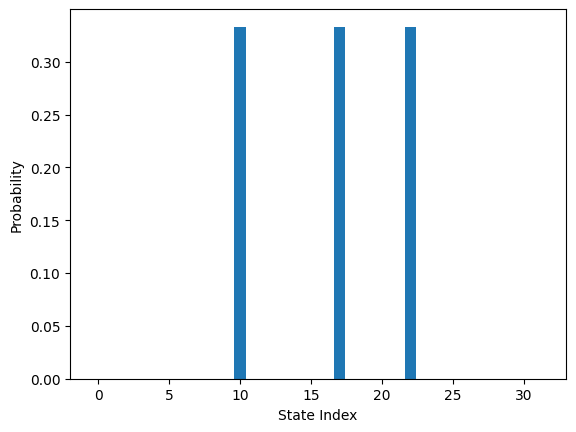

In [9]:
import matplotlib.pyplot as plt

top_indices = np.argsort(probs)[-M:][::-1]
letters = ['A', 'B', 'C', 'D', 'E']

print("Grover result: ")
for idx in top_indices:
  binary = format(idx, f'0{n}b')
  symbol = [letters[i] for i in range(len(binary)) if binary[i] == '1']
  symbol.sort()
  print(f"Subset: ({''.join(symbol)}), Prob: {probs[idx]:.4f}")

plt.bar(range(2**n), probs)
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.show()